# Import Packages

In [138]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.ndimage as ndi 
from skimage import filters, io 
from skimage.filters import try_all_threshold, roberts, sobel
from skimage.color import gray2rgb , rgb2gray
from PIL import Image
from collections import Counter
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
import skimage
from skimage.measure import label
from skimage.transform import resize

import warnings
warnings.simplefilter("ignore", UserWarning)


# <center style='background-color:gray; border-radius: 30px 0px 30px 0px;margin-left:350px ;width:50%; hight:10px; color:white;'>Problem Description</center>

___in this kernal we will try to classify lung ct scans to normal or Benign or Malignant image___
- 
 - ___First of all this problem is a more challenging problem because___
- The lungs can have varying sizes and shapes across different individuals, and even within the same individual. This variability can make it challenging to develop a segmentation algorithm that can accurately identify the lungs in all cases.
- The CT scans may contain other structures in addition to the lungs, such as the chest wall, diaphragm, and blood vessels. These structures can have similar intensities to the lung tissue, making it difficult to distinguish between them.
- The dataset contains Limited scans, which may not be enough to train a deep learning-based segmentation model from scratch. This can limit the performance of the segmentation algorithm, as deep learning models typically require large amounts of labeled data to achieve high accuracy.

___steps I took to solve this problem___
- dataset separated as a 4 classes adenocarcinoma, large.cell.carcinoma, normal, squamous.cell.carcinoma
- do some analysis on the image to get some notes to help us segment it.
- Extract lung from the image and Adjust the size of images to be consistent.
- Testing different models to determine their respective accuracies.


 <h1>view types </h1>
<img src='https://cancercarespecialists.org/wp-content/uploads/2021/04/CT-axial-coronal-sagittal-e1619201386483.jpg'></img>

___Note___
- The data in this data set is in Axial view

In [129]:
directory = r"C:\Users\Ahmed\Documents\zzz\Data2"

categories = ['adenocarcinoma', 'large.cell.carcinoma','normal','squamous.cell.carcinoma']

In [107]:
# Utility Functions
def hist(image, title='Image'):
    '''Function for draw historgrame for values in image'''
    fig,ax= plt.subplots(figsize=(20,7),nrows=1,ncols=1)
    ax.hist(image.ravel(),bins=30,color='gray')
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
    
def show(img, title='Image'):
    '''Function for visualize sigle image'''
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def load_scans(INPUT_FOLDER):
    '''Function for load scans'''
    imgs=[]
    for i in os.listdir(INPUT_FOLDER):
        imgs.append(cv2.imread(INPUT_FOLDER+'/'+i))
    return imgs

def show_slices(st,rows,cols):
    '''Function to load multiple images'''
    fig, axs = plt.subplots(rows,cols,figsize=(rows+5,cols+5))
    axs = axs.flatten()
    for i in range(rows*cols):
        axs[i].imshow(st[i],cmap='gray')
        axs[i].axis('off')
    plt.show()
    
def normalize(gray):
    '''Functoin for make all values in image between 0 and 1'''
    MIN_BOUND = gray.min()
    MAX_BOUND = gray.max()
    gray = (gray - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    gray[gray>1] = 1.
    gray[gray<0] = 0.
    return gray

# <center style='background-color:gray; border-radius: 30px 0px 30px 0px;margin-left:350px ;width:50%; hight:10px; color:white;'>explor data</center>

In [108]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_list = []
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = cv2.imread(filepath).shape
        temp_list.append(f"{height} x {width}")
    
    size_data[i] = dict(Counter(temp_list))


c:\Users\Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


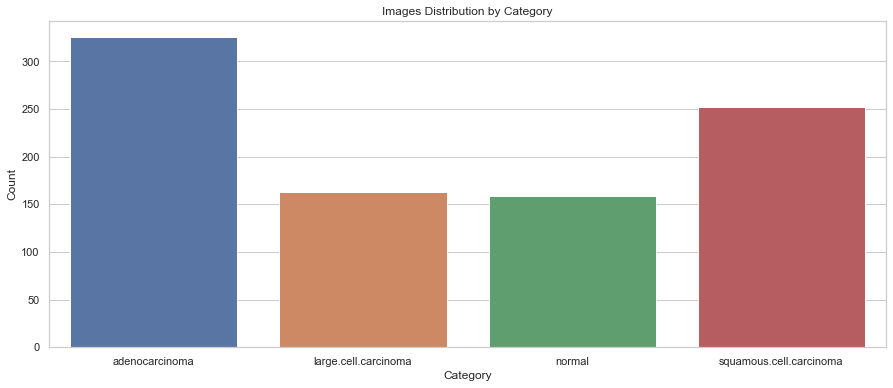

In [139]:
# Create lists of categories and their corresponding counts
cat = []
counts = []
for i in categories:
    cat.append(i)
    counts.append(len(os.listdir(os.path.join(directory, i))))

# Use Seaborn to create the first bar plot
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 6))
sns.set(style="whitegrid")
sns.barplot(cat,counts, ax=ax1, ci=None)
ax1.set(xlabel='Category', ylabel='Count', title='Images Distribution by Category')
ax1.tick_params(axis='x')
plt.show()

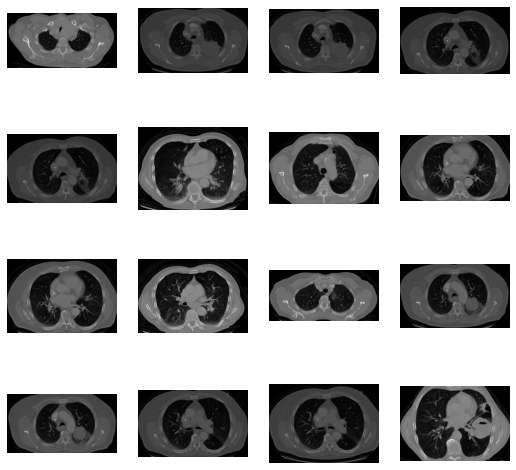

In [137]:
malignant_folder= r"C:\Users\Ahmed\Documents\zzz\Data2\large.cell.carcinoma"
data = load_scans(malignant_folder)
show_slices(data , 4,4)

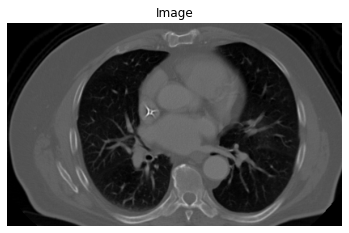

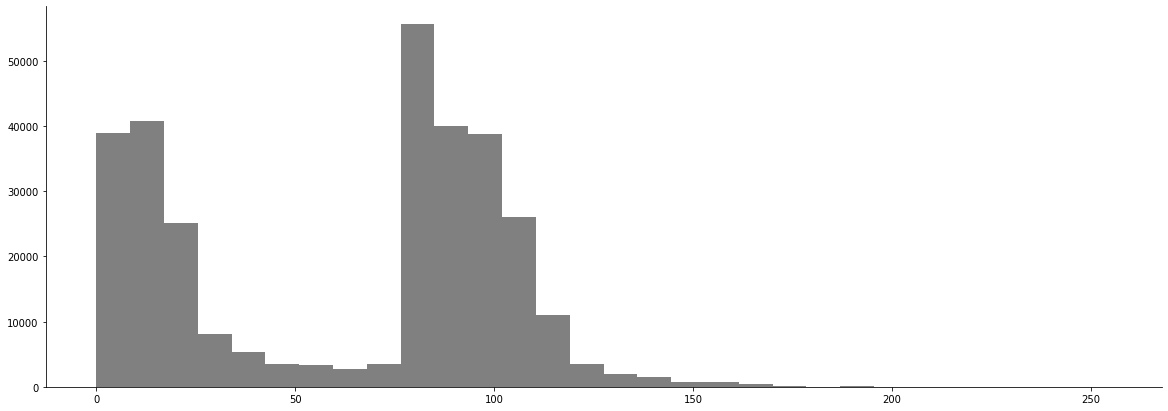

In [42]:
show(data[7])
hist(data[7])

### ___obsjervations___
- images have range from 0 to 256
- images have diffrent contrast
- images have three main components
    - background
    - diaphragm
    - blood vessels

#### now i will try some thresholds for choose one for segmentation

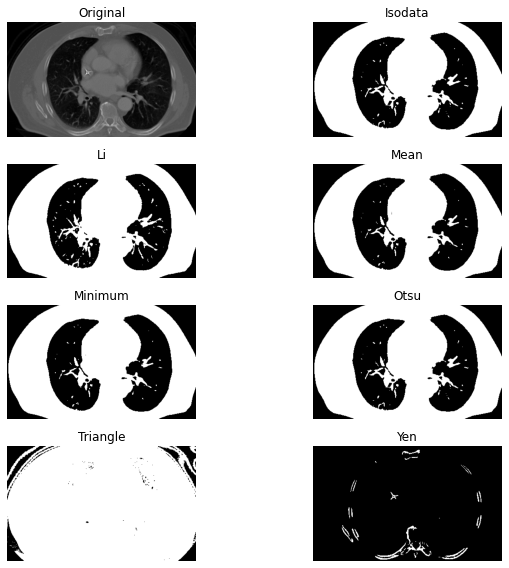

In [43]:
fig, ax = try_all_threshold(rgb2gray(data[7]), figsize=(10, 8), verbose=False)
plt.show()

<h3>I think Isodata threshold is so good</h3>

# <center style='background-color:gray; border-radius: 30px 0px 30px 0px;margin-left:350px ;width:50%; hight:10px; color:white;'>segmentation Function </center>

___The filter_labels function calls six smaller functions:___

- find_corners: This function finds the corner labels in the input labels image.
- calculate_objects_size: This function computes the size of each connected component in the input labels image and returns a dictionary of labels to sizes, after removing the corner labels.
- sort_labels_by_size: This function sorts the label-size dictionary by size.
- remove_small_objects: This function removes labels whose size is less than or equal to 1000 pixels from the sorted label-size list.
- remove_diaphragm: This function removes the diaphragm label from the filtered label-size list, which is the first object encountered when drawing lines from the center of the image to each corner of the image.
- create_cleaned_labels: This function creates a new labels image containing only the objects in the filtered label-size list.
- get_left_and_right_labels: This function computes the centroid of each object in the cleaned labels image, sorts them by x-coordinate value, and selects the leftmost and rightmost objects as the left and right labels.

In [44]:
from skimage import measure


def filter_labels(labels, nlabels):
    corners = find_corners(labels)
    object_sizes = calculate_objects_size(labels, corners)
    sorted_sizes = sort_labels_by_size(object_sizes)
    filtered_sizes = remove_small_objects(sorted_sizes)
    diaphragm_label = remove_diaphragm(labels, filtered_sizes)
    cleaned_labels = create_cleaned_labels(labels, filtered_sizes)
    left_label, right_label = get_left_and_right_labels(cleaned_labels)
    
    return [left_label, right_label]


def find_corners(labels):
    h, w = labels.shape[:2]
    corners = set([labels[0, 0], labels[0, w-1], labels[h-1, 0], labels[h-1, w-1]])
    return corners


def calculate_objects_size(labels, corners):
    object_sizes = Counter(labels.ravel())
    for corner in corners:
        del object_sizes[corner]
    return object_sizes


def sort_labels_by_size(object_sizes):
    sorted_sizes = sorted(object_sizes.items(), key=lambda x: x[1])
    return sorted_sizes


def remove_small_objects(sorted_sizes):
    filtered_sizes = [size_tuple for size_tuple in sorted_sizes if size_tuple[1] > 1000]
    return filtered_sizes


def remove_diaphragm(labels, filtered_sizes):
    h, w = labels.shape[:2]
    st = set()

    for i in range(h):
        if (labels[i, i],) in filtered_sizes:
            st.add((labels[i, i],))

        if (labels[h-i-1, i],) in filtered_sizes:
            st.add((labels[h-i-1, i],))

        if (labels[h-i-1, w-i-1],) in filtered_sizes:
            st.add((labels[h-i-1, w-i-1],))

    filtered_sizes = list(set(filtered_sizes) - st)

    diaphragm_label = label if label in labels else None
    return diaphragm_label

def create_cleaned_labels(labels, filtered_sizes):
    cleaned_labels = np.zeros_like(labels)
    for size_tuple in filtered_sizes:
        obj_label = size_tuple[0]
        obj_mask = np.where(labels == obj_label, 1, 0)
        cleaned_labels += obj_mask * obj_label
    return cleaned_labels


def get_left_and_right_labels(labels):
    regions = measure.regionprops(labels)
    centroids = [r.centroid for r in regions]
    
    # Sort the centroids based on their x-coordinate values
    centroids.sort(key=lambda x: x[0])
    
    # Find the two objects with smallest x-coordinates
    left_obj_centroid, right_obj_centroid = centroids[:2]
    left_label, right_label = None, None
    for region in regions:
        if tuple(region.centroid) == tuple(left_obj_centroid):
            left_label = region.label
        elif tuple(region.centroid) == tuple(right_obj_centroid):
            right_label = region.label
            
    return left_label, right_label

In [45]:
def segmentation(slice,flag=0):
    '''convert image to gray scale'''
    if len(slice.shape) == 3:
        slice = rgb2gray(slice)
    else:
        slice = slice
        
    '''normalize values in image to be in range 0 for 1'''
    img_eq = normalize(slice)
    
    '''binarize image to remove back ground'''
    thresh = filters.threshold_isodata(img_eq)
    binary =( img_eq< thresh)

    '''label images for detect objects in image'''
    labels, nlabels = ndi.label(binary)
    '''this filter_labels function for returning left and right lungs from objects in the image'''

    try:
        first, second = filter_labels(labels, nlabels)
            
    except:
        return np.zeros((256, 256, 3))

    '''this line to extract two lungs with their colors from the main image'''
    lungs= np.where((labels == first) | (labels == second),1,0) * slice

    '''this for get bounded lungs from image and resize image to make all images with same size'''
    bboxes= ndi.find_objects(np.where((labels == first) | (labels == second),1,0))
    im_res= slice[bboxes[0]]
    new_size = (256, 256)
    
    image_resized = resize(im_res, new_size, order=0, mode='reflect', anti_aliasing=False)
    
    sharpened_image = filters.unsharp_mask(image_resized, radius=1, amount=1)
    
    if flag:
        show_slices([slice,img_eq,binary,labels,lungs,sharpened_image],3,2)

    return gray2rgb(sharpened_image)

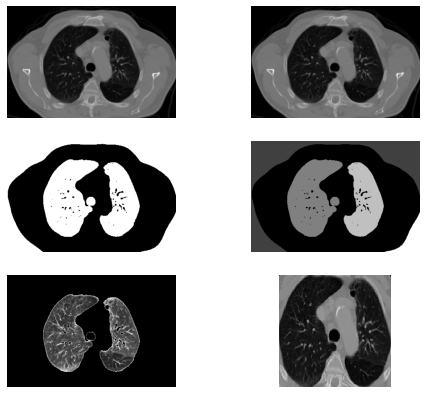

In [46]:
img = cv2.imread(r'C:\Users\Ahmed\Documents\zzz\Data2\large.cell.carcinoma\000015.png')
res = segmentation(img,1)

# <center style='background-color:gray; border-radius: 30px 0px 30px 0px;margin-left:350px ;width:50%; hight:10px; color:white;'>Preparing Data </center>

In [47]:
import os
import cv2
import random
from collections import Counter
import numpy as np

# Initialize variables
data = []
img_size = 256

# Loop over categories and their files
for i, category in enumerate(categories):
    for file in os.listdir(os.path.join(directory, category)):
        img = cv2.imread(os.path.join(directory, category, file), 0)
        
        # Preprocess image and skip if maximum pixel value is 0
        img = segmentation(img)
        if img.max() == 0:
            continue
        
        # Append image and label to data list
        data.append([img, i])

# Shuffle data randomly
random.shuffle(data)

# Extract features and labels from data
X, y = zip(*data)

# Print length of X and count of each unique value in y
print('X length:', len(X))
print('y counts:', Counter(y))

# Convert features and labels to numpy arrays
X = np.array(X)
y = np.array(y)


X length: 835
y counts: Counter({0: 320, 3: 239, 1: 147, 2: 129})


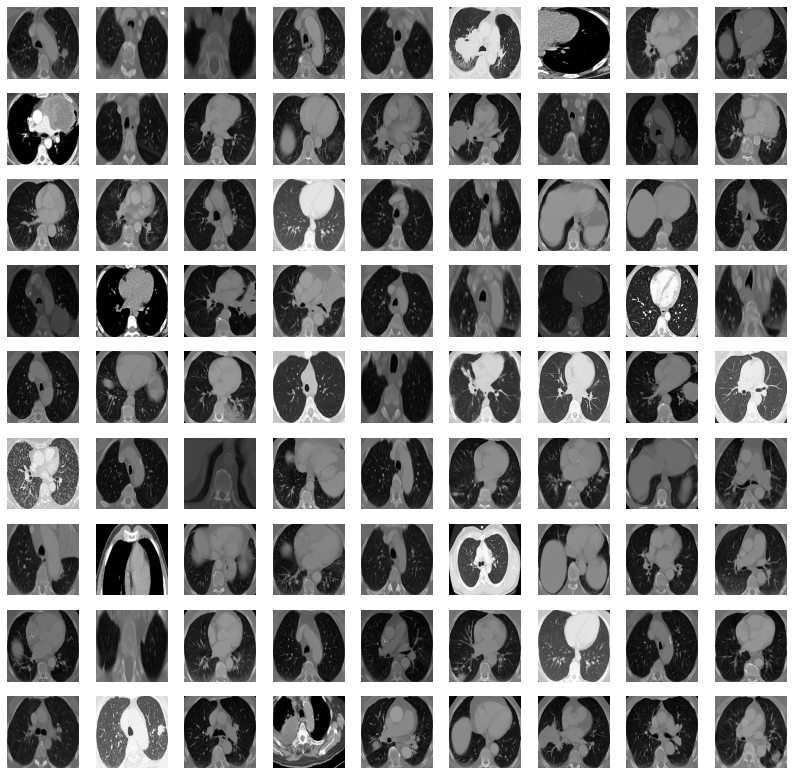

In [62]:
show_slices(X,9,9)

In [49]:
X.shape

(835, 256, 256, 3)

In [50]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(534, 256, 256, 3)
(134, 256, 256, 3)
(167, 256, 256, 3)


# <center style='background-color:gray; border-radius: 30px 0px 30px 0px;margin-left:350px ;width:50%; hight:10px; color:white;'>Apply smoting for avoid bias  </center>

In [51]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


def apply_smote(X_train, y_train):
    # Flatten each image in X_train
    X_train_flat = np.reshape(X_train, (X_train.shape[0], -1))

    # Print the distribution of classes before applying SMOTE
    print("Class Distribution Before SMOTE:", Counter(y_train))

    # Apply SMOTE to balance the training set
    smote = SMOTE()
    X_train_sampled, y_train_sampled = smote.fit_resample(X_train_flat, y_train.ravel())

    # Reshape the flattened images back to their original shape
    X_train_sampled = np.reshape(X_train_sampled, (X_train_sampled.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))

    # Print the distribution of classes after applying SMOTE
    print("Class Distribution After SMOTE:", Counter(y_train_sampled))

    return X_train_sampled, y_train_sampled



In [53]:
X_train_sampled, y_train_sampled = apply_smote(X_train, y_train)
X_valid_sampled, y_valid_sampled = apply_smote(X_valid, y_valid)
X_test_sampled, y_test_sampled = apply_smote(X_test, y_test)

Class Distribution Before SMOTE: Counter({0: 199, 3: 154, 1: 95, 2: 86})
Class Distribution After SMOTE: Counter({0: 199, 3: 199, 1: 199, 2: 199})
Class Distribution Before SMOTE: Counter({0: 52, 3: 39, 1: 28, 2: 15})
Class Distribution After SMOTE: Counter({3: 52, 0: 52, 1: 52, 2: 52})
Class Distribution Before SMOTE: Counter({0: 69, 3: 46, 2: 28, 1: 24})
Class Distribution After SMOTE: Counter({3: 69, 0: 69, 1: 69, 2: 69})


In [54]:
print('X_train_sampled',X_train_sampled.shape)
print('X_valid_sampled',X_valid_sampled.shape)
print('X_test_sampled',X_test_sampled.shape)

X_train_sampled (796, 256, 256, 3)
X_valid_sampled (208, 256, 256, 3)
X_test_sampled (276, 256, 256, 3)


# <center style='background-color:gray; border-radius: 30px 0px 30px 0px;margin-left:350px ;width:50%; hight:10px; color:white;'>Modeling </center>

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create an instance of the VGG16 model with pre-trained weights
vgg = VGG16(weights='imagenet', include_top=False, input_shape=X_train_sampled.shape[1:])

# Freeze the convolutional layers in the base model so they are not updated during training
for layer in vgg.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Use data augmentation to generate additional training data
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()


y_train_onehot = to_categorical(y_train_sampled)
y_valid_onehot = to_categorical(y_valid_sampled)


# Compile the model with a lower learning rate and categorical hinge loss
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_hinge', optimizer=opt, metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-end-Data-WoW2.hdf5', monitor='val_loss', verbose=3, save_best_only=True)
# Define early stopping criteria to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model using the augmented data generator and early stopping
history = model.fit(datagen_train.flow(X_train_sampled, y_train_onehot, batch_size=14, shuffle=True),
                    epochs=15,
                    validation_data=datagen_val.flow(X_valid_sampled, y_valid_onehot, batch_size=14, shuffle=True),
                    callbacks=[checkpointer,early_stop],
                    shuffle=True)




Epoch 1/15
57/57 [==============================] - ETA: 0s - loss: 0.9659 - accuracy: 0.4786
Epoch 1: val_loss improved from inf to 0.75155, saving model to .\chest_CT_SCAN-end-Data-WoW2.hdf5
57/57 [==============================] - 249s 4s/step - loss: 0.9659 - accuracy: 0.4786 - val_loss: 0.7515 - val_accuracy: 0.6442
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.6307
Epoch 2: val_loss did not improve from 0.75155
57/57 [==============================] - 252s 4s/step - loss: 0.7463 - accuracy: 0.6307 - val_loss: 0.8116 - val_accuracy: 0.5913
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.7274
Epoch 3: val_loss improved from 0.75155 to 0.49690, saving model to .\chest_CT_SCAN-end-Data-WoW2.hdf5
57/57 [==============================] - 276s 5s/step - loss: 0.5831 - accuracy: 0.7274 - val_loss: 0.4969 - val_accuracy: 0.8173
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.4298 - ac

In [57]:
y_test_onehot = to_categorical(y_test)
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6/6 [==============================] - 28s 5s/step - loss: 0.1744 - accuracy: 0.9341
Test loss: 0.17442424595355988
Test accuracy: 0.9341317415237427


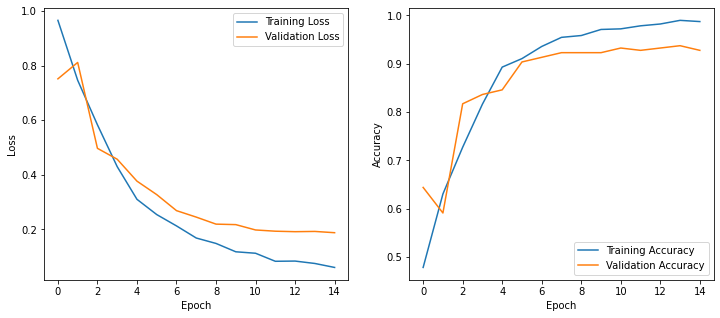

In [58]:


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.legend(loc='upper right')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend(loc='lower right')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.show()


In [59]:
# Calculate accuracy and loss
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

# Predict on validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Print classification report
from sklearn.metrics import classification_report
target_names = categories
print(classification_report(y_true, y_pred_classes, target_names=target_names))

6/6 [==============================] - 34s 5s/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.97      0.94        69
   large.cell.carcinoma       0.92      0.92      0.92        24
                 normal       0.93      0.96      0.95        28
squamous.cell.carcinoma       0.98      0.87      0.92        46

               accuracy                           0.93       167
              macro avg       0.94      0.93      0.93       167
           weighted avg       0.94      0.93      0.93       167



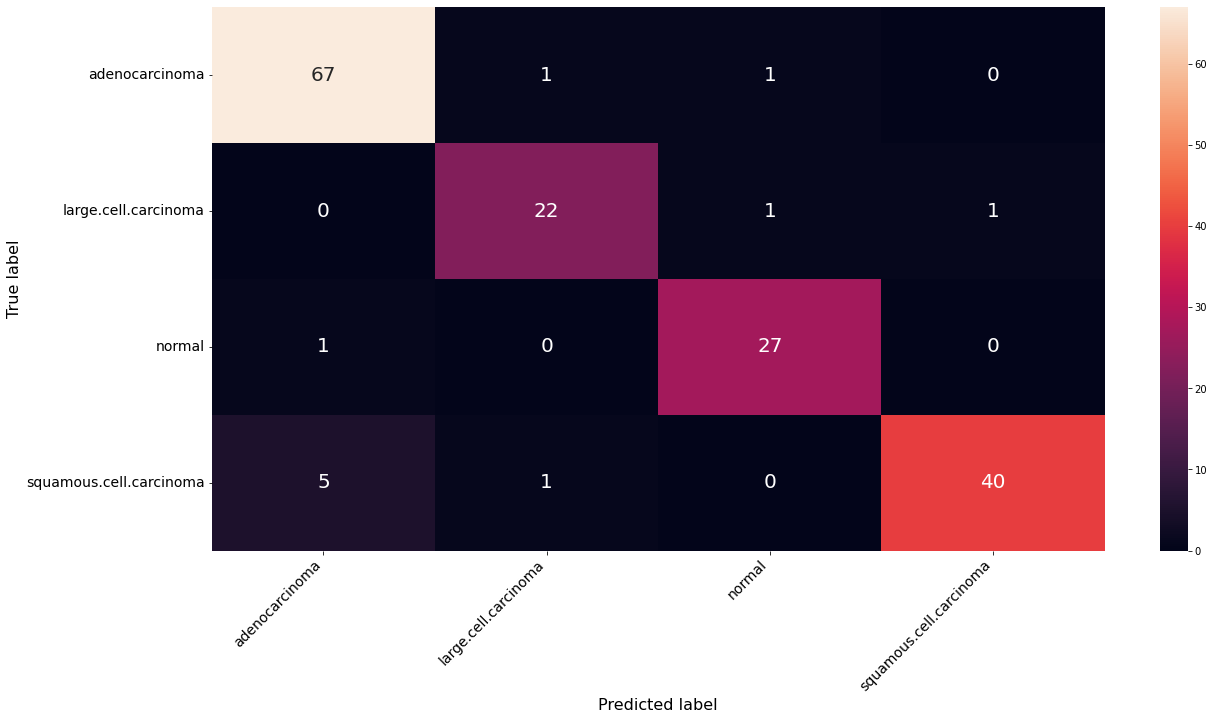

In [60]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=categories, yticklabels=categories, annot_kws={"fontsize":20})

ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=14)
ax.set_yticklabels(categories, rotation=0, ha='right', fontsize=14)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.show()
